# Cài đặt

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

**Lưu ý:** từ Scikit-Learn 0.24, theo mặc định thì `fetch_openml()` sẽ trả về một `DataFrame` của Pandas.
Để tránh điều này và giữ tính nhất quán với đoạn mã trong sách, ta sẽ đặt `as_frame=False`.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

d:\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

Saving figure some_digit_plot


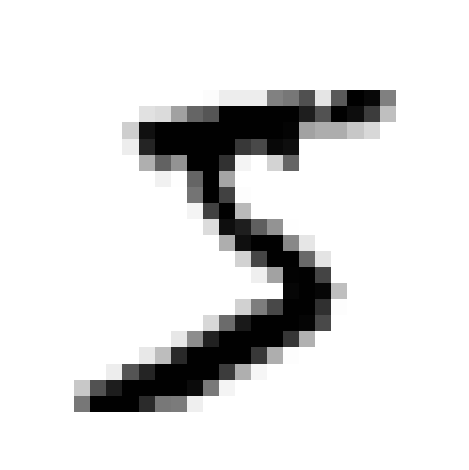

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


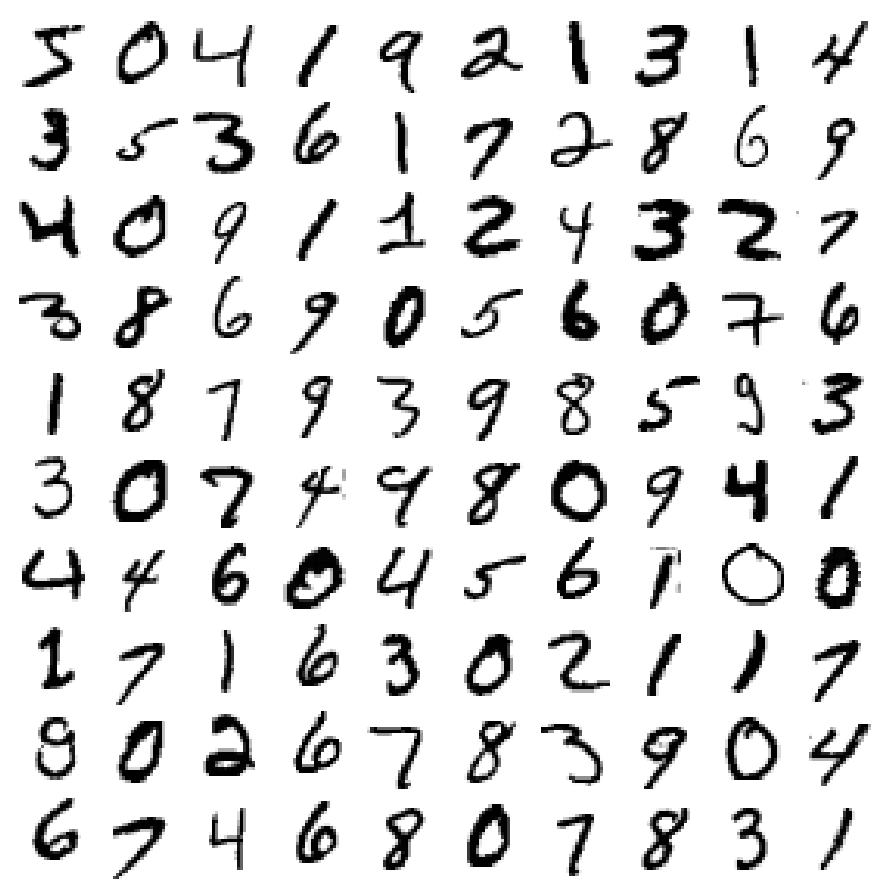

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [12]:
y[0]

5

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Bộ phân loại nhị phân

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Ghi chú**: giá trị mặc định của một vài siêu tham số sẽ được thay đổi trong các phiên bản sau này của Scikit-Learn, ví dụ như `max_iter` và `tol`.
Để tương thích với các phiên bản mới, ta sẽ đặt luôn các giá trị mặc định trong các phiên bản tương lai cho các siêu tham số này.
Việc này không được trình bày trong sách để giữ các đoạn mã ngắn gọn.

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


**Ghi chú**: `shuffle=True` vô tình bị bỏ quên trong các phiên bản trước của cuốn sách.

In [19]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**Lưu ý**: đầu ra ở đây (và ở nhiều chỗ khác trong notebook này cũng như các notebook khác) có thể sẽ khác một chút so với trong sách.
Đừng lo lắng, vì điều đó hoàn toàn bình thường! Lý do là bởi một vài nguyên nhân sau đây:
* Đầu tiên, Scikit-Learn và các thư viện khác đều được phát triển, và các thuật toán được tinh chỉnh một chút dẫn đến việc kết quả có thể bị thay đổi.
Nếu bạn dùng phiên bản Scikit-Learn mới nhất (khuyến nghị nên dùng bản mới nhất), khả năng cao là phiên bản đó sẽ khác với phiên bản được sử dụng trong cuốn sách hay notebook này, từ đó gây ra sự khác biệt.
Tôi luôn cố gắng cập nhật notebook này một cách hợp lý, nhưng tôi không thể thay đổi các con số trong cuốn sách mà bạn đang có.
* Thứ hai, nhiều thuật toán huấn luyện mang tính ngẫu nhiên. 
Về nguyên tắc, ta có thể thu được đầu ra nhất quán từ bộ sinh số ngẫu nhiên bằng cách đặt seed.
Giá trị này sẽ được sử dụng để sinh các con số giả ngẫu nhiên (vậy nên bạn sẽ thường thấy `random_state=42` hoặc `np.random.seed(42)`).
Tuy nhiên, đôi khi việc này vẫn chưa đủ do các yếu tố khác được liệt kê ở đây.
* Thứ ba, nếu thuật toán huấn luyện chạy trên nhiều luồng (như các thuật toán được lập trình bằng ngôn ngữ C) hoặc nhiều tiến trình (ví dụ như khi sử dụng tham số `n_jobs`), chưa chắc thứ tự thực hiện các phép toán sẽ được giữ nguyên, do đó kết quả chính xác có thể thay đổi một chút.
* Cuối cùng, một vài yếu tố khác có thể ngăn cản việc tái tạo hoàn chỉnh. Ví dụ, thứ tự trong `dict` và `set` của Python có thể sẽ không được giữ nguyên ở các lần chạy khác nhau, hoặc tương tự với thứ tự của các tệp trong một thư mục.

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [23]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [29]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [32]:
y_some_digit_pred

array([ True])

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


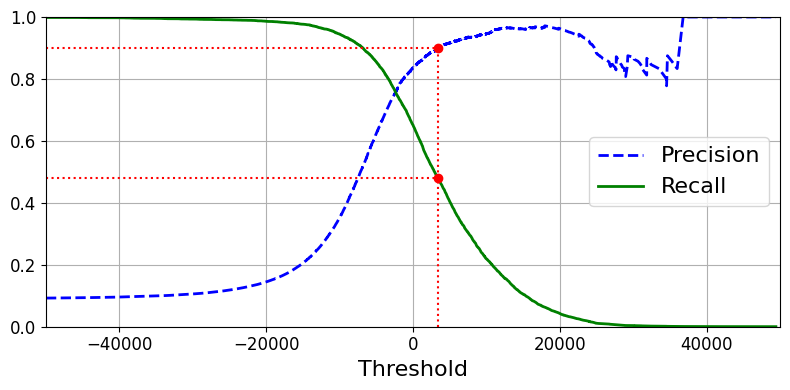

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


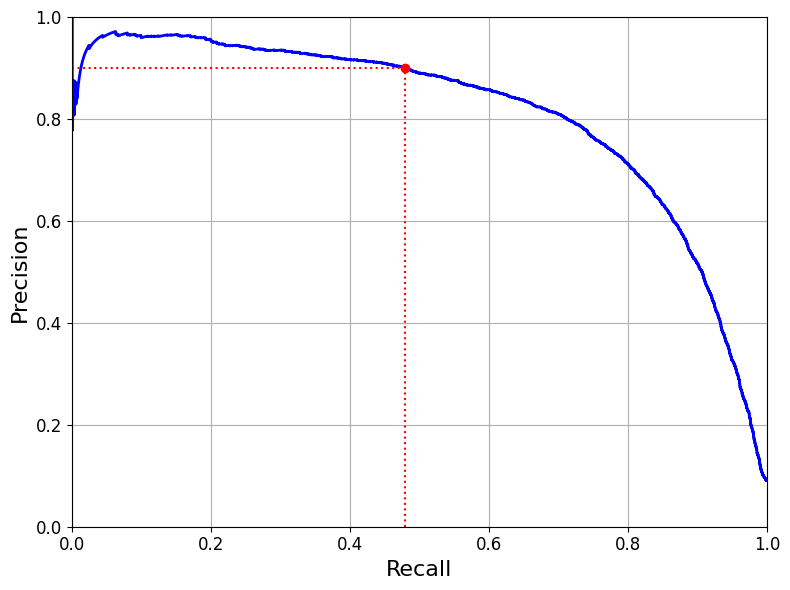

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [40]:
threshold_90_precision

3370.0194991439557

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# Đường cong ROC

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


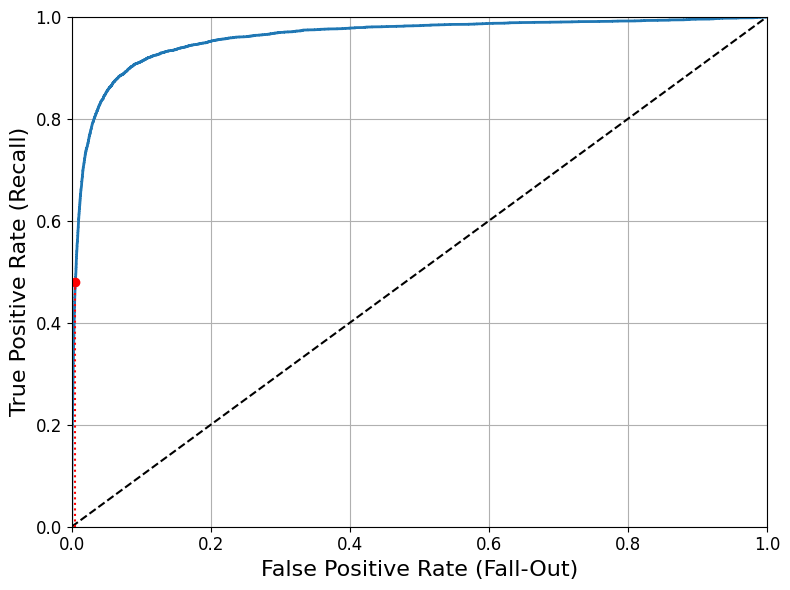

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Ghi chú**: ta đặt `n_estimators=100` để thích ứng với phiên bản sau này vì đây sẽ là giá trị mặc định trong Scikit-Learn 0.22.

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [48]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


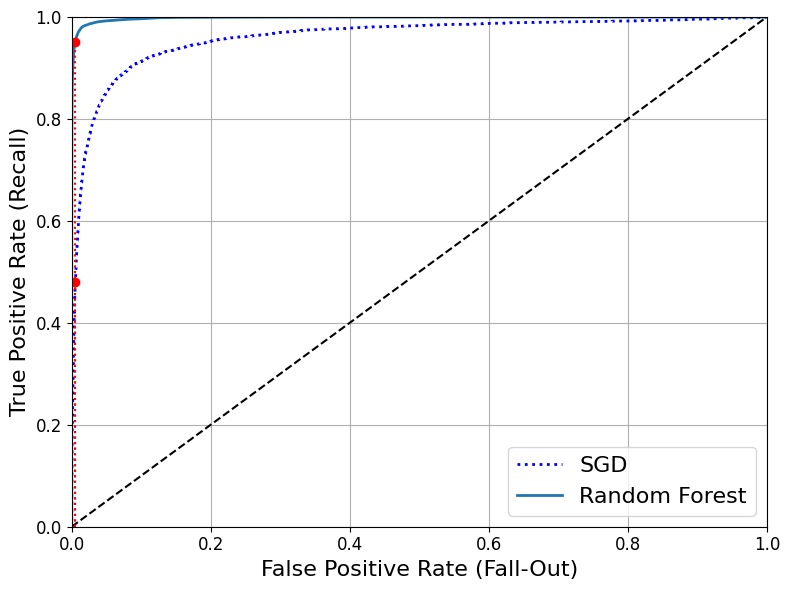

In [49]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Phân loại đa lớp

In [53]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [55]:
np.argmax(some_digit_scores)

5

In [56]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [57]:
svm_clf.classes_[5]

5

In [58]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
len(ovr_clf.estimators_)

10

In [60]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [61]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**Lưu ý**: hai cell dưới đây có thể sẽ mất gần 30 phút hoặc hơn để chạy, tùy vào phần cứng của bạn.

In [62]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Phân tích lỗi

In [64]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [65]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


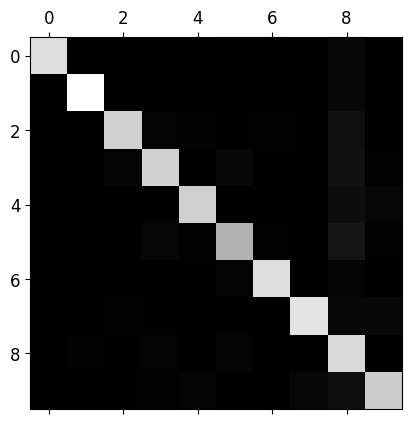

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


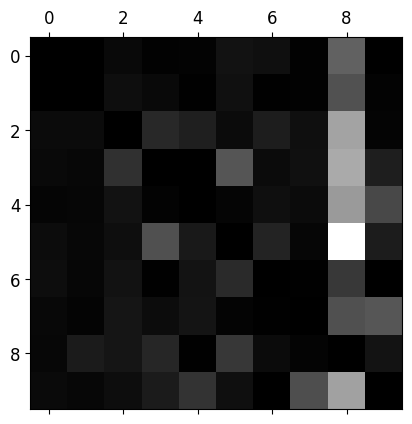

In [68]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


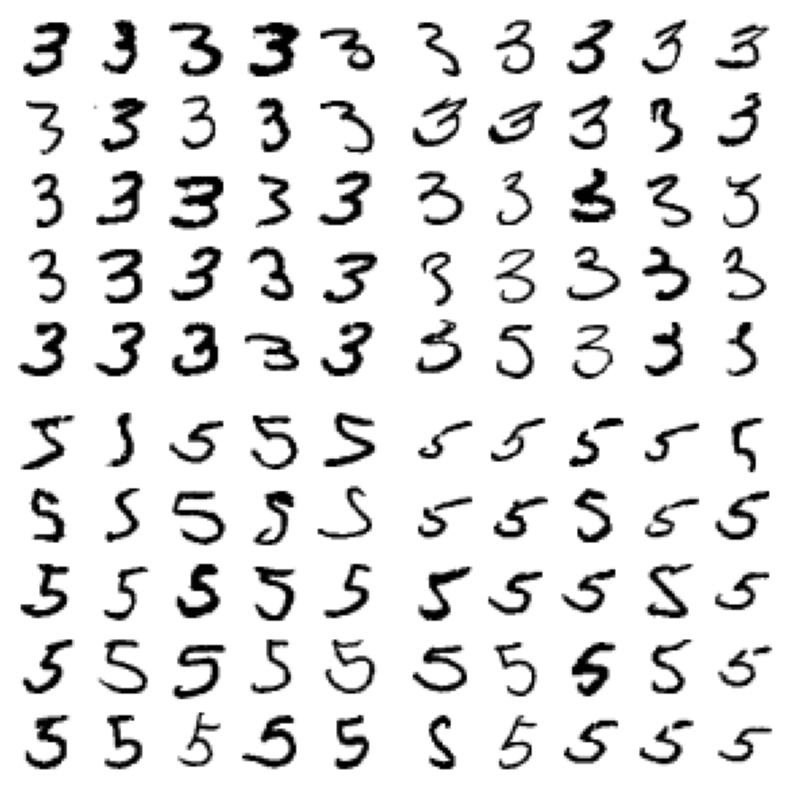

In [69]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Phân loại đa lớp

In [70]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Lưu ý**: cell dưới đây có thể sẽ chạy rất lâu (có thể lên đến hàng tiếng, tùy vào phần cứng của bạn).

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Phân loại đa đầu ra

In [73]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


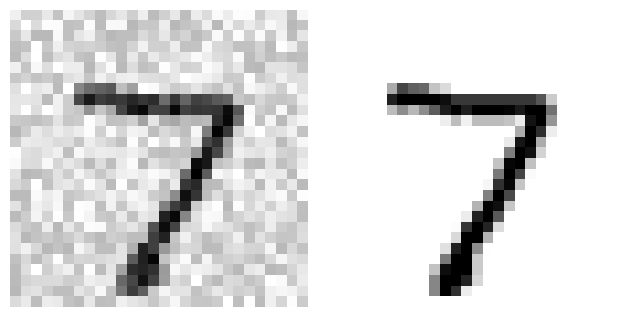

In [74]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


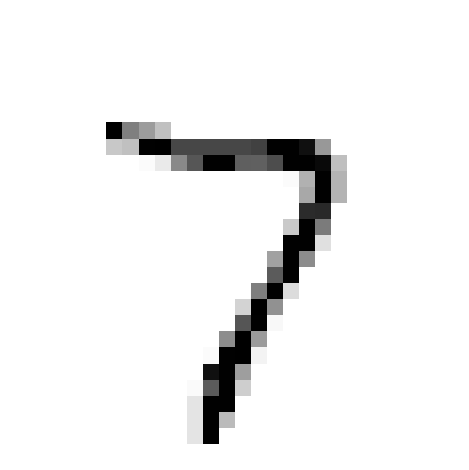

In [75]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# Phần bổ sung

## Bộ phân loại giả (tức ngẫu nhiên) 

In [76]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

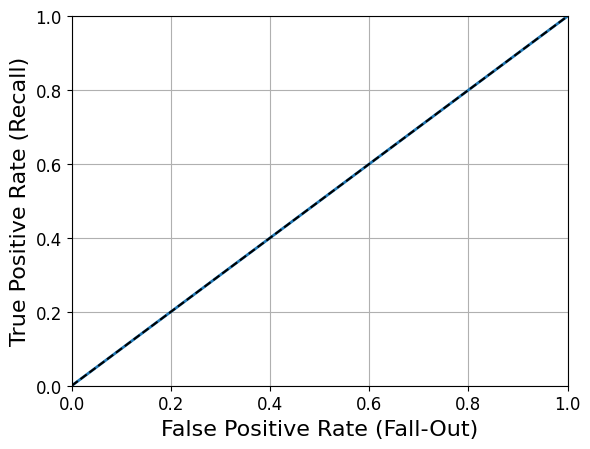

In [77]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## Bộ phân loại KNN

In [78]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [79]:
y_knn_pred = knn_clf.predict(X_test)

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

C:\Users\TUF GAMING\AppData\Local\Temp\ipykernel_10480\3518175631.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


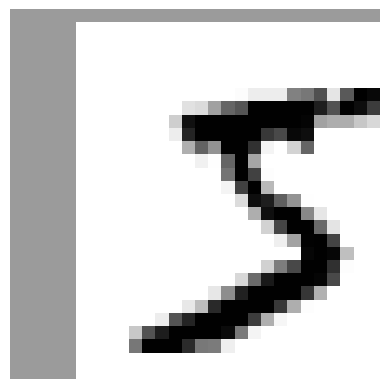

In [81]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [82]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [83]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [84]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [85]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [86]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

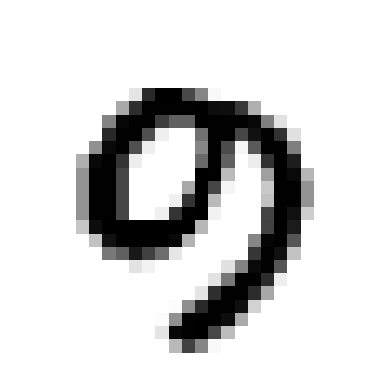

In [87]:
plot_digit(ambiguous_digit)

# Lời giải bài tập

## 1. Bộ phân loại MNIST với Độ chính xác hơn 97%

**Lưu ý**: cell dưới đây có thể sẽ mất 16 tiếng để chạy hoặc hơn, tùy vào phần cứng của bạn.

In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  16.6s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  13.4s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  13.4s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  25.5s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  15.2s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  13.5s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  13.3s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  13.7s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  13.5s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  21.9s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  17.9s
[CV 2/5] END ....n_neighbors=4, weights=uniform;, score=0.968 total time=  14.9s
[CV 3/5] END ....n_neighbors

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [89]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [90]:
grid_search.best_score_

0.9716166666666666

In [91]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2. Tăng cường Dữ liệu

In [92]:
from scipy.ndimage.interpolation import shift

C:\Users\TUF GAMING\AppData\Local\Temp\ipykernel_10480\987197595.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [93]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

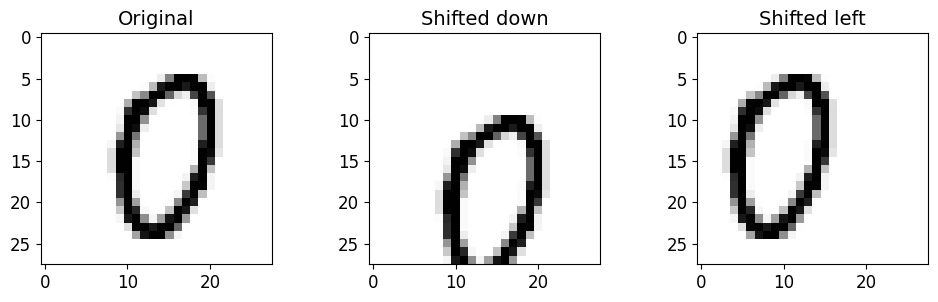

In [94]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [95]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [96]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [97]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [98]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

**Lưu ý**: cell dưới đây có thể sẽ mất gần một tiếng để chạy, tùy vào phần cứng của bạn.

In [99]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

Chỉ với việc tăng cường dữ liệu, độ chính xác đã tăng 0.5%. :)

## 3. Làm việc với tập dữ liệu Titanic

Mục tiêu là dự đoán xem hành khách có sống sót hay không dựa vào các thuộc tính như tuổi tác, giới tính, hạng hành khách, điểm đến, v.v.

Đầu tiên, hãy đăng nhập vào [Kaggle](https://www.kaggle.com/) và tìm [thử thách Titanic](https://www.kaggle.com/c/titanic) để tải `train.csv` và `test.csv`.
Hãy lưu chúng vào thư mục `datasets/titanic`.

Tiếp đến, hãy nạp dữ liệu:

In [100]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [101]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [102]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

Dữ liệu đã được chia sẵn thành hai tập huấn luyện và kiểm tra.
Tuy nhiên, dữ liệu kiểm tra *không* chứa nhãn:
mục tiêu của bạn là huấn luyện mô hình tốt nhất có thể với dữ liệu huấn luyện, rồi đưa ra dự đoán trên dữ liệu kiểm tra và tải chúng lên Kaggle để biết điểm số cuối cùng.

Hãy cùng nhìn qua một vài hàng đầu tiên của tập huấn luyện:

In [103]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Các thuộc tính có ý nghĩa như sau:
* **Survived**: là mục tiêu với 0 - hành khách không sống sót và 1 - hành khách sống sót.
* **Pclass**: hạng hành khách
* **Name**, **Sex**, **Age**: tên, giới tính, tuổi
* **SibSp**: số lượng anh chị em & vợ/chồng cũng lên tàu Titanic của hành khách đó
* **Parch**: số lượng con & cha mẹ cũng lên tàu Titanic của hành khách đó
* **Ticket**: mã vé
* **Fare**: giá vé (tính bằng Bảng Anh)
* **Cabin**: mã số phòng của hành khách
* **Embarked**: điểm đến của hành khách

Hãy lấy thêm thông tin để xem dữ liệu có bị thiếu nhiều không:

In [104]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Các thuộc tính **Age**, **Cabin** và **Embarked** thi thoảng bị rỗng (có ít hơn 891 giá trị khác rỗng), đặc biệt là **Cabin** (77% rỗng).
Ta sẽ tạm thời bỏ qua **Cabin** và tập trung vào các thuộc tính còn lại.
Thuộc tính **Age** có khoảng 19% giá trị rỗng, nên ta cần phải quyết định xem nên làm gì với chúng.
Việc thay giá trị rỗng bằng tuổi trung vị có vẻ hợp lý.

Hai thuộc tính **Name** và **Ticket** có thể sẽ hữu ích, nhưng sẽ hơi khó để biến đổi chúng về dạng số để có thể đưa chúng vào mô hình.
Vì vậy, ta cũng sẽ tạm bỏ qua hai thuộc tính này.

Hãy cùng xem xét các thuộc tính số:

In [105]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Sặc, chỉ có 38% hành khách sống sót (**Survived**). :( Con số này khá gần với 40%, nên độ chính xác là phép đo phù hợp để đánh giá mô hình.
* Giá vé (**Fare**) trung bình là 32.20 Bảng Anh, dường như không đắt lắm (nhưng có thể là rất nhiều tiền tại thời điểm đó).
* Đổ tuổi (**Age**) trung bình thấp hơn 30.

Hãy xác minh rằng giá trị mục tiêu sẽ chỉ bằng 0 hoặc 1:

In [106]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Giờ hãy xem qua tất cả các thuộc tính hạng mục:

In [107]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [108]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [109]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Thuộc tính Embarked cho biết điểm đến của hành khách: C=Cherbourg, Q=Queenstown, S=Southampton.

**Ghi chú**: đoạn mã dưới đây kết hợp `Pipeline`, `FeatureUnion` và một `DataFrameSelector` tùy chỉnh để tiền xử lý các cột theo các cách khác nhau.
Từ Scikit-Learn 0.20 trở đi, bạn nên dùng `ColumnTransformer`, tương tự như trong chương trước.

Giờ hãy xây dựng pipeline tiền xử lý.
Ta sẽ sử dụng lại `DataFrameSelector` ở chương trước để lựa chọn các thuộc tính nhất định từ `DataFrame`:

In [110]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Hãy xây dựng pipeline cho các thuộc tính số:

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [112]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

Ta cũng sẽ cần một "imputer" cho các cột hạng mục dưới dạng xâu ký tự (`SimpleImputer` không dùng được cho các cột này):

In [113]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [114]:
from sklearn.preprocessing import OneHotEncoder

Giờ ta có thể xây dựng pipeline cho các thuộc tính hạng mục:

In [115]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [116]:
cat_pipeline.fit_transform(train_data)

d:\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Cuối cùng, hãy kết nối hai pipeline cho thuộc tính số và hạng mục lại với nhau:

In [117]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Tuyệt! Giờ ta đã có một pipeline tiền xử lý với khả năng nhận vào dữ liệu thô và trả về các đặc trưng đầu vào dưới dạng số.
Ta có thể đưa các đặc trưng này vào bất kỳ mô hình Học Máy nào mà ta muốn.

In [118]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

d:\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Đừng quên trích xuất các nhãn:

In [119]:
y_train = train_data["Survived"]

Giờ ta đã sẵn sàng để huấn luyện một bộ phân loại.
Hãy bắt đầu với `SVC`:

In [120]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

Tuyệt, mô hình đã được huấn luyện xong. Giờ hãy dùng nó để đưa ra dự đoán trên tập kiểm tra:

In [121]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

Và giờ ta có thể tạo một tệp CSV chứa các dự đoán này (theo định dạng được chấp nhận bởi Kaggle), rồi tải lên và hy vọng mọi chuyện sẽ suôn sẻ.
Nhưng khoan! Ta không cần phải hy vọng.
Sao ta không sử dụng kiểm định chéo để xem mô hình hoạt động tốt đến đâu?

In [122]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

Độ chính xác đạt hơn 73%, rõ ràng tốt hơn việc đoán mò, nhưng chưa phải là một điểm số tốt.
Nếu nhìn vào [bảng xếp hạng](https://www.kaggle.com/c/titanic/leaderboard) của cuộc thi Titanic trên Kaggle, bạn sẽ thấy rằng độ chính xác cần phải đạt hơn 80% để lọt vào top 10% Kaggler.
Một vài người còn đạt được 100%, nhưng vì bạn có thể dễ dàng tra cứu [danh sách nạn nhân](https://www.encyclopedia-titanica.org/titanic-victims/) của vụ tai nạn, khả năng cao là Học Máy đã không đóng góp nhiều vào kết quả của họ! ;-)
Vì thế, hãy cố gắng xây dựng một mô hình đạt độ chính xác chỉ 80%.

Hãy thử dùng `RandomForestClassifier`:

In [123]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

Kết quả tốt hơn hẳn!

Thay vì chỉ nhìn vào độ chính xác trung bình của 10 fold kiểm định chéo, hãy vẽ đồ thị của 10 điểm số ứng với mỗi mô hình, cùng với một biểu đồ hộp để biểu diễn tứ phân vị dưới và trên, cũng như "râu" để biểu diễn khoảng giá trị của điểm số (cảm ơn Nevin Yilmaz vì đã đề xuất cách trực quan hóa như vậy).
Chú ý rằng hàm `boxplot()` có thể phát hiện các điểm ngoại lai và sẽ không sử dụng chúng khi vẽ râu.
Cụ thể, nếu ta gọi tứ phân vị dưới là $Q_1$ và tứ phân vị trên là $Q_3$, ta sẽ có khoảng tứ phân vị (interquartile range) $IQR = Q_3 - Q_1$ (đây là chiều cao của chiếc hộp).
Mọi điểm số nhỏ hơn $Q_1 - 1.5 \times IQR$ hay lớn hơn $Q3 + 1.5 \times IQR$ sẽ được coi là ngoại lai.

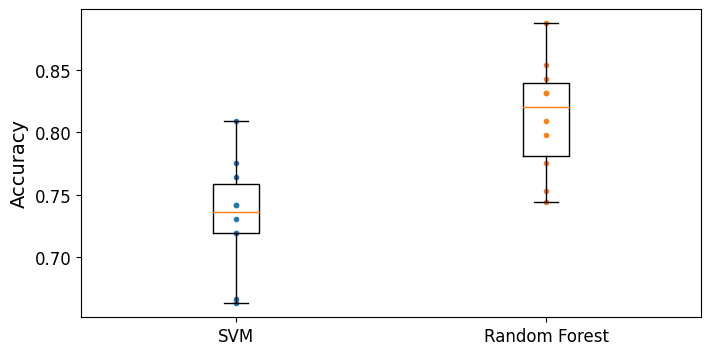

In [124]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Để cải thiện kết quả trên hơn nữa, bạn có thể:
* So sánh nhiều mô hình hơn và tinh chỉnh siêu tham số bằng kiểm định chéo và tìm kiếm dạng lưới
* Thực hiện thiết kế đặc trưng nhiều hơn, ví dụ:
  * Thay thế **SibSp** và **Parch** bằng tổng của chúng
  * Thử tìm kiếm những từ trong tên hành khách có tính tương quan cao với thuộc tính **Survived** (ví dụ, nếu tên hành khách chứa từ "Countess", có nghĩa là "nữ bá tước", hành khách này sẽ có khả năng sống sót cao hơn
  * Thử biến đổi các thuộc tính số thành thuộc tính hạng mục: ví dụ, các nhóm tuổi khác nhau có tỉ lệ sống sót rất khác nhau (xem ở dưới), nên việc sử dụng nhóm tuổi như hạng mục thay vì dùng trực tiếp tuổi có thể sẽ hữu ích.
  Tương tự, ta cũng có thể tạo một hạng mục dành riêng cho những hành khách du hành một mình, vì chỉ có 30% trong số họ sống sót (xem ở dưới)

In [125]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [126]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. Bộ phân loại thư rác

Đầu tiên, hãy tải dữ liệu về:

In [127]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [128]:
fetch_spam_data()

Tiếp theo, hãy nạp tất cả email:

In [129]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [130]:
len(ham_filenames)

2500

In [131]:
len(spam_filenames)

500

Ta có thể dùng mô-đun `email` của Python để đọc các email này (mô-đun này xử lý email header, việc mã hóa ký tự, v.v.):

In [132]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [133]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Hãy xem qua một email bình thường và một email rác để hình dung được dữ liệu:

In [134]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [135]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Một vài email có nhiều phần, bao gồm ảnh và tệp đính kèm (có thể có cả các tệp đính kém con).
Hãy cùng xem qua các loại cấu trúc khác nhau:

In [136]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [137]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [138]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [139]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

Có vẻ đa số các email bình thường đều có dạng văn bản thô, trong khi email rác có khá nhiều HTML.
Hơn nữa, khá nhiều email bình thường được ký bằng PGP, trong khi không hề có email rác nào được ký.
Nói ngắn gọn, có vẻ cấu trúc email là một thông tin hữu ích.

Giờ hãy cùng xem qua header của các email:

In [140]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

Dường như có khá nhiều thông tin hữu ích nằm trong đó, ví dụ như địa chỉ email của người gửi (12a1mailbot1@web.de trông có vẻ khả nghi), nhưng ta sẽ chỉ tập trung vào phần `Subject` trong header:

In [141]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

Được rồi, trước khi ta tìm hiểu quá sâu về dữ liệu, hãy đừng quên chia chúng thành hai tập huấn luyện và kiểm tra:

In [142]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Hãy bắt đầu viết các hàm để tiền xử lý.
Đầu tiên, ta sẽ cần một hàm để biển đổi HTML về dạng văn bản thô.
Có vẻ cách tốt nhất để thực hiện việc này là sử dụng thư viện [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), nhưng tôi muốn hạn chế việc thêm dependency vào dự án, nên giải quyết nhanh vấn đề này bằng biểu thức chính quy (nhưng với nguy cơ gặp phải ["un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment"](https://stackoverflow.com/a/1732454/38626)).
Hàm dưới đây loại bỏ phần `<head>`, rồi biến đổi tất cả các thẻ `<a>` thành từ HYPERLINK, sau đó loại bỏ tất cả các thẻ HTML và chỉ giữ lại văn bản thô.
Để giúp kết quả dễ đọc hơn, hàm này cũng thay thế nhiều dòng mới liên tiếp thành một dòng mới duy nhất.
Cuối cùng, hàm này bỏ ký tự thoát trong các ký tự thực thể HTML (như `&gt;` hay `&nbsp;`).

In [143]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Hãy thử xem hàm này có hoạt động đúng không.
Dưới đây là đoạn HTML trong một email rác:

In [144]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

Và văn bản thô thu được:

In [145]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

Tuyệt vời! Giờ hãy viết một hàm để nhận đầu vào là một email với định dạng bất kỳ và trả về nội dung email dưới dạng văn bản thô:

In [146]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [147]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Giờ hãy thực hiện biến đổi từ về dạng gốc (stemming)!
Để làm điều đó, bạn cần phải cài đặt Natural Language Toolkit ([NLTK](http://www.nltk.org/)).
Bạn chỉ cần chạy câu lệnh sau (và đừng quên kích hoạt virtualenv trước; nếu không có virtualenv, bạn sẽ cần có quyền admin hoặc phải dùng option `--user`):

`$ pip3 install nltk`

In [148]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Error: stemming requires the NLTK module.


Ta cũng cần một cách để thay thế các URL bằng từ "URL".
Để làm vậy, ta có thể theo hướng khó nhằn hơn bằng cách sử dụng [biểu thức chính quy](https://mathiasbynens.be/demo/url-regex), nhưng ở đây ta sẽ dùng thư viện [urlextract](https://github.com/lipoja/URLExtract).
Bạn có thể cài đặt thư viện này bằng câu lệnh sau (cũng đừng quên kích hoạt virtualenv trước; nếu không có virtualenv, bạn sẽ cần có quyền admin hoặc phải dùng option `--user`):

`$ pip3 install urlextract`

In [149]:
# if running this notebook on Colab or Kaggle, we just pip install urlextract
if IS_COLAB or IS_KAGGLE:
    !pip install -q -U urlextract

In [150]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


Ta đã sẵn sàng để lắp ghép mọi thứ lại với nhau thành một bộ biến đổi, rồi dùng nó để biến email thành tập hợp chứa số lượng của mỗi từ.
Lưu ý rằng ta sẽ chia câu thành các từ bằng phương thức `split()` của Python, và phương thức này dùng dấu cách để ngăn cách các từ trong câu.
Điều này phù hợp với nhiều ngôn ngữ viết, nhưng không phải tất cả.
Ví dụ, các văn bản tiếng Trung hay tiếng Nhật thường không có dấu cách giữa các từ, và tiếng Việt còn dùng dấu cách trong từ ghép.
Trong bài tập này thì không có vấn đề gì, vì (hầu hết) tập dữ liệu được viết bằng tiếng Anh.

In [151]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Hãy thử dùng bộ biến đổi này trên một vài email:

In [152]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christianity': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'one': 2, 'on': 2, 'been': 2, 'has': 2, 'half': 2, 'jesus': 2, 'some': 1, 'interesting': 1, 'quotes': 1, 'http': 1, 'www': 1, 'postfun': 1, 'com': 1, 'pfp': 1, 'worbois': 1, 'html': 1, 'thomas': 1, 'examined': 1, 'known': 1, 'superstitions': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'superstition': 1, 'redeeming': 1, 'feature': 1, 'they': 1, 'are': 1, 'alike': 1, 'founded': 1, 'fables': 1, 'mythology': 1, 'millions': 1, 'innocent': 1, 'men': 1, 'women': 1, 'children': 1, 'since': 1, 'introduction': 1, 'burnt': 1, 'tortured': 1, 'fined': 1, 'imprisoned': 1, 'what': 1, 'effect': 1, 'this': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fools': 1, 'other': 1, 'hypocrites': 1, 'support': 1, 'roguery': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1

Kết quả trông có vẻ đúng!

Giờ ta đã có các tập hợp chứa số lượng từ, và ta cần biến đổi chúng thành vector.
Để làm vậy, ta sẽ xây dựng một bộ biến đổi khác.
Phương thức `fit()` của bộ biến đổi này sẽ xây dựng bảng từ vựng, còn phương thức `transform()` sẽ dùng bảng từ vựng đó để biến đổi tập hợp chứa số lượng từ thành vector.
Kết quả thu được sẽ là một ma trận thưa.

In [153]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [154]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [155]:
X_few_vectors.toarray()

array([[  6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [112,  11,   9,   8,   3,   1,   0,   1,   3,   0,   1],
       [ 92,   0,   1,   2,   3,   4,   5,   3,   1,   4,   2]],
      dtype=int32)

Ma trận này có ý nghĩa gì?
Con số 99 ở hàng thứ hai, cột đầu tiên có nghĩa là email thứ hai chứa 99 từ không tồn tại trong bảng từ vựng.
Số 11 ngay cạnh đó có nghĩa là từ đầu tiên trong bảng từ vựng xuất hiện 11 lần trong email này.
Số 9 tiếp theo có nghĩa là từ thứ hai xuất hiện 9 lần, và cứ tiếp tục như thế.
Bạn có thể nhìn vào bảng từ vựng để biết những từ đó là từ nào.
Từ đầu tiên là "the", và từ thứ hai là "of", v.v.

In [156]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'http': 5,
 'NUMBER': 6,
 'com': 7,
 'all': 8,
 'yahoo': 9,
 'in': 10}

Giờ ta đã sẵn sàng để huấn luyện bộ phân loại thư rác đầu tiên! Hãy biến đổi toàn bộ tập dữ liệu:

In [157]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

**Ghi chú**: để thích ứng với các phiên bản sau này, ta đặt `solver=lbfgs` vì đây sẽ là giá trị mặc định trong Scikit-Learn 0.22.

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.983) total time=   0.2s
[CV] END ................................ score: (test=0.984) total time=   0.3s
[CV] END ................................ score: (test=0.993) total time=   0.4s


0.9862500000000001

Hơn 98.5%, không tệ đối với lần thử đầu tiên! :)
Tuy nhiên, hãy nhớ rằng ta đang sử dụng tập dữ liệu "dễ".
Bạn có thể thử các tập dữ liệu khó hơn, và kết quả sẽ không tốt như thế này.
Bạn sẽ phải thử nhiều mô hình khác nhau, rồi chọn các mô hình tốt nhất và tinh chỉnh chúng, v.v.

Nhưng vì bạn đã nắm được bức tranh tổng thể, ta sẽ tạm dừng ở đây và chỉ in ra precision/recall trên tập kiểm tra:

In [159]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 98.94%
Recall: 97.89%
